## PyTorch 模型保存&读取
- 模型存储
- 模型单卡存储&多卡存储
- 模型单卡读取&多卡读取
- 模型剪裁&量化

## 1、模型存储
- PyTorch存储模型主要采用pkl，pt，pth三种格式,就使用层面来说没有区别
- PyTorch模型主要包含两个部分：模型结构和权重。其中模型是继承nn.Module的类，权重的数据结构是一个字典（key是层名，value是权重向量）
- 存储也由此分为两种形式：存储整个模型（包括结构和权重）和只存储模型权重。

In [2]:
import torch
from torchvision import models
model = models.resnet50(pretrained=True)
save_dir = './resnet50.pth'

# 保存整个模型
torch.save(model, save_dir)
# 保存模型权重
torch.save(model.state_dict, save_dir)

# pt, pth和pkl三种数据格式均支持模型权重和整个模型的存储

## 2、模型单卡存储&多卡存储
- PyTorch中将模型和数据放到GPU上有两种方式——.cuda()和.to(device)
- 注：如果要使用多卡训练的话，需要对模型使用torch.nn.DataParallel

### 2.1、nn.DataParrallel

<CLASS torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)>
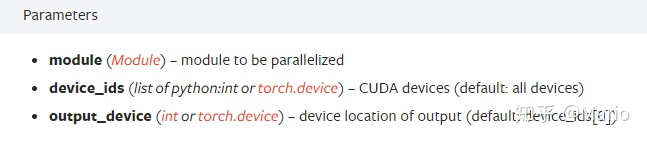

- module即表示你定义的模型
- device_ids表示你训练的device
- output_device这个参数表示输出结果的device，而这最后一个参数output_device一般情况下是省略不写的，那么默认就是在device_ids[0] 

注：因此一般情况下第一张显卡的内存使用占比会更多


In [5]:
import os
import torch
from torchvision import models

In [3]:
#单卡
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # 如果是多卡改成类似0,1,2
model = model.cuda()  # 单卡


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

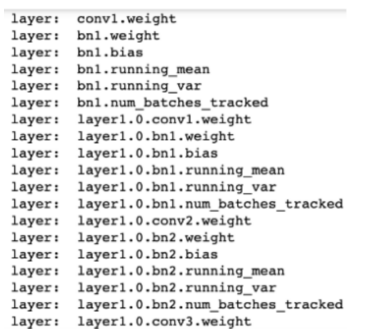

In [ ]:
#多卡
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
model = torch.nn.DataParallel(model).cuda()  # 多卡

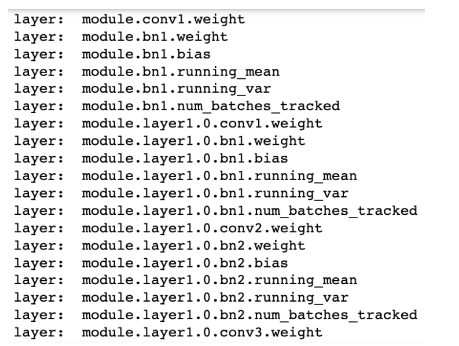

### 2.3、单卡保存+单卡加载

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'   #这里替换成希望使用的GPU编号
model = models.resnet50(pretrained=True)
model.cuda()

save_dir = 'resnet50.pt'   #保存路径

# 保存+读取整个模型
torch.save(model, save_dir)
loaded_model = torch.load(save_dir)
loaded_model.cuda()

# 保存+读取模型权重
torch.save(model.state_dict(), save_dir)
# 先加载模型结构
loaded_model = models.resnet50()   
# 在加载模型权重
loaded_model.load_state_dict(torch.load(save_dir))
loaded_model.cuda()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### 2.4、单卡保存+多卡加载

In [ ]:

os.environ['CUDA_VISIBLE_DEVICES'] = '0'   #这里替换成希望使用的GPU编号
model = models.resnet50(pretrained=True)
model.cuda()

# 保存+读取整个模型
torch.save(model, save_dir)

os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'   #这里替换成希望使用的GPU编号
loaded_model = torch.load(save_dir)
loaded_model = nn.DataParallel(loaded_model).cuda()

# 保存+读取模型权重
torch.save(model.state_dict(), save_dir)

os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'   #这里替换成希望使用的GPU编号
loaded_model = models.resnet50()   #注意这里需要对模型结构有定义
loaded_model.load_state_dict(torch.load(save_dir))
loaded_model = nn.DataParallel(loaded_model).cuda()

### 2.5、多卡保存+单卡加载

- 如何去掉权重字典键名中的"module"，以保证模型的统一性
- 对于加载整个模型，直接提取模型的module属性即可
- 对于加载模型权重，保存模型时保存模型的module属性对应的权重

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'   #这里替换成希望使用的GPU编号

model = models.resnet50(pretrained=True)
model = nn.DataParallel(model).cuda()

# 保存+读取整个模型
torch.save(model, save_dir)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'   #这里替换成希望使用的GPU编号
loaded_model = torch.load(save_dir).module

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'   #这里替换成希望使用的GPU编号

save_dir = 'resnet50.pth'   #保存路径
model = models.resnet50(pretrained=True)
model = nn.DataParallel(model).cuda()

# 保存权重
torch.save(model.module.state_dict(), save_dir)

#加载模型权重
os.environ['CUDA_VISIBLE_DEVICES'] = '0'   #这里替换成希望使用的GPU编号
loaded_model = models.resnet50()   #注意这里需要对模型结构有定义
loaded_model.load_state_dict(torch.load(save_dir))
loaded_model = nn.DataParallel(loaded_model).cuda()
loaded_model.state_dict = loaded_dict


### 2.6、多卡保存+多卡加载
保存整个模型时会同时保存所使用的GPU id等信息，读取时若这些信息和当前使用的GPU信息不符则可能会报错或者程序不按预定状态运行。可能出现以下2个问题：
- 1、读取整个模型再使用nn.DataParallel进行分布式训练设置，这种情况很可能会造成保存的整个模型中GPU id和读取环境下设置的GPU id不符，训练时数据所在device和模型所在device不一致而报错
- 2、读取整个模型而不使用nn.DataParallel进行分布式训练设置，发现程序会自动使用设备的前n个GPU进行训练（n是保存的模型使用的GPU个数）。此时如果指定的GPU个数少于n，则会报错

#### 建议方案：

- 读取模型权重，之后再使用nn.DataParallel进行分布式训练设置则没有问题
- 因此多卡模式下建议使用权重的方式存储和读取模型

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'   #这里替换成希望使用的GPU编号

model = models.resnet50(pretrained=True)
model = nn.DataParallel(model).cuda()

# 保存+读取模型权重，强烈建议！！
torch.save(model.state_dict(), save_dir)
loaded_model = models.resnet50()   #注意这里需要对模型结构有定义
loaded_model.load_state_dict(torch.load(save_dir)))
loaded_model = nn.DataParallel(loaded_model).cuda()

## 建议
- 不管是单卡保存还是多卡保存，建议以保存模型权重为主
- 不管是单卡load还是多卡load,先load模型权重，再指定是多卡load或单卡load
